In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy import mean

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
connection = engine.connect()


In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

In [10]:
#   Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)
# Calculate the date 1 year ago from the last data point in the database
first_date = dt.date(2017,8,23) - dt.timedelta(days=365)
print(first_date)

# Query the last 12 months of precipitation scores and sort by date
date_filter = Measurement.date >= '2016-08-23'

last_year = session.query(Measurement.date, Measurement.prcp).filter(date_filter).order_by(Measurement.date).all()

last_year_date = [date[0] for date in last_year]
last_year_prcp = [prcp[1] for prcp in last_year]

# Save the query results as a Pandas DataFrame, drop the rows with missing values, and set the index to the date column
last_year_prcp_df = pd.DataFrame({"Date": last_year_date,
                                  "Precipitation": last_year_prcp
                                 })
#drop rows with missing values
last_year_prcp_df = last_year_prcp_df.dropna()
#convert date from sting to datetime
last_year_prcp_df['Date'] = pd.to_datetime(last_year_prcp_df['Date'])
#se index to Date
last_year_prcp_df = last_year_prcp_df.set_index("Date")
# Display the dataframe
last_year_prcp_df


('2017-08-23',)
2016-08-23


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


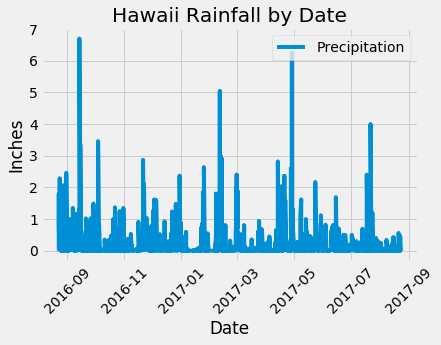

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(last_year_prcp_df.index,last_year_prcp_df["Precipitation"], label="Precipitation")
plt.xticks( rotation="45")
plt.title("Hawaii Rainfall by Date")
plt.legend(loc="upper right")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
#create dataframe to display the mean, median, variance, standard deviation, and SEM of the Precipitation
summary_stats_df = pd.DataFrame({"Summary Statistic": ["Precipitation Mean", "Precipitation Median", "Precipitation Variance", "Precipitation Stnd Deviation", "Precipitation SEM"],
                                 "Precipitation in Inches": [last_year_prcp_df["Precipitation"].mean(),
                                                        last_year_prcp_df["Precipitation"].median(),
                                                        last_year_prcp_df["Precipitation"].var(),
                                                        last_year_prcp_df["Precipitation"].std(),
                                                        last_year_prcp_df["Precipitation"].sem()]
                                })
#Display the summary statistics table
summary_stats_df = summary_stats_df.set_index("Summary Statistic")
summary_stats_df


,Precipitation in Inches
Summary Statistic,
Precipitation Mean,0.177279
Precipitation Median,0.020000
Precipitation Variance,0.212696
Precipitation Stnd Deviation,0.461190
Precipitation SEM,0.010259


In [13]:
# Design a query to show how many stations are available in this dataset?
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the observation counts in descending order.

session.query((Measurement.station), func.count(Measurement.station).label('station_count')).\
    group_by(Measurement.station).\
    order_by(desc('station_count')).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature for the last 12 months within the database
station_filter = Measurement.station == 'USC00519281'

temp_results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(station_filter).filter(date_filter).all()

min_t= [temp[0] for temp in temp_results]
min_t= min_t[0]

max_t= [temp[1] for temp in temp_results]
max_t= max_t[0]

avg_t= [temp[2] for temp in temp_results]
avg_t= round(avg_t[0],2)

temp_stats_df = pd.DataFrame({"Temperature Statistic": ["Lowest temperature", "Highest temperature", "Average temperature"],
                                 "Temperature in (F)": [min_t, max_t, avg_t]
                                })
temp_stats_df


,Temperature Statistic,Temperature in (F)
0,Lowest temperature,59.00
1,Highest temperature,83.00
2,Average temperature,73.11


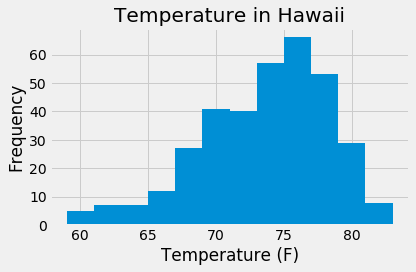

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_list = []


last_year_temp = session.query(Measurement.tobs).filter(station_filter).filter(date_filter).all()
for temps in last_year_temp:
    temp_list.append(temps[0])

plt.hist(temp_list, 12)
plt.title('Temperature in Hawaii')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


## Bonus Challenge Assignment

In [16]:
### Temperature Analysis I  ###

# Is there a meaningful difference between the temperature in Hawaii during June and December?
# Null hypothesis: There is no significant difference in the temperature in Hawaii in June and December.

# Collect all of the temperature measurements for June and for Decamber
june_temps = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == '06').all()
all_june_temps = [temp[0] for temp in june_temps]

dec_temps = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == '12').all()
all_dec_temps = [temp[0] for temp in dec_temps]

# Print the average temperature in June and in December using all stations across all available years in the dataset
print(f'The average temperature in Hawaii for June is {round(np.mean(all_june_temps),2)}(F)')
print(f'The average temperature in Hawaii for December is {round(np.mean(all_dec_temps),2)}(F)')
# Unpaired (independent) t-test
# I used the unpaired t-test because the data was taken at different times in various locations.
# There were more temperature observations made in June than in December
# Null hypothesis: There is no significant difference in the temperature in Hawaii in June and December.
print(f''' 
The difference in temperatures in Hawaii during June and December are not statistically significant.
The null hypothesis cannot be rejected.
The T-Test results:  {stats.ttest_ind(all_june_temps, all_dec_temps)}
''')


The average temperature in Hawaii for June is 74.94(F)
The average temperature in Hawaii for December is 71.04(F)
 
The difference in temperatures in Hawaii during June and December are not statistically significant.
The null hypothesis cannot be rejected.
The T-Test results:  Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)



In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
    Returns:
        TMIN, TAVE, and TMAX
    """
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_temp_stats = calc_temps('2017-03-01', '2017-03-10')
trip_min_temp = trip_temp_stats[0][0]
trip_avg_temp = round(trip_temp_stats[0][1],2)
trip_max_temp = trip_temp_stats[0][2]

print(trip_min_temp , trip_avg_temp , trip_max_temp)


62.0 70.34 78.0


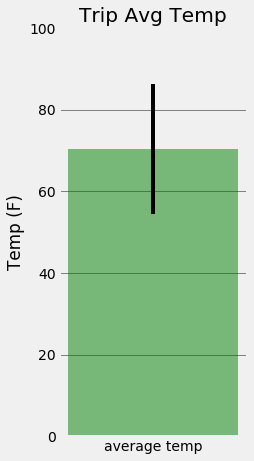

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(3,7))
plt.bar("average temp", trip_avg_temp, color='green', alpha=0.5, yerr = (trip_max_temp - trip_min_temp))
plt.grid(color='grey', axis='y', linewidth=1)
plt.grid( axis='x', linewidth=0)
plt.title("Trip Avg Temp")
plt.yticks(np.arange(0, 110, 20))
plt.ylabel("Temp (F)")
plt.show()


In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

precip_per_station_df = pd.read_sql(
    ''' 
    select a.station, b.name, round(sum(a.prcp),2) as total_prcp, b.latitude, b.longitude, b.elevation
    from measurement a
    join station b
        on (a.station = b.station)
    where a.date >= '2017-03-01' and a.date <= '2017-03-10'
    group by a.station
    order by total_prcp
    ;
    ''',
    connection
    )
precip_per_station_df

,station,name,total_prcp,latitude,longitude,elevation
0,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1.75,21.52130,-157.83740,7.0
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2.32,21.33556,-157.71139,19.5
2,USC00519397,"WAIKIKI 717.2, HI US",2.74,21.27160,-157.81680,3.0
3,USC00517948,"PEARL CITY, HI US",2.98,21.39340,-157.97510,11.9
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",3.50,21.33310,-157.80250,152.4
5,USC00519281,"WAIHEE 837.5, HI US",5.39,21.45167,-157.84889,32.9
6,USC00513117,"KANEOHE 838.1, HI US",5.73,21.42340,-157.80150,14.6


In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    Args:
        date (str): A date string in the format '%m-%d'   
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    """
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

trip_days = ["03-01","03-02","03-03","03-04","03-05","03-06","03-07","03-08","03-09","03-10" ]

# Loop through the list of %m-%d strings and calculate the normals for each date
for day in trip_days:
    normals.append(daily_normals(day))
    
normals    

[[(64.0, 70.0327868852459, 76.0)],
 [(61.0, 70.36666666666666, 78.0)],
 [(60.0, 70.06896551724138, 78.0)],
 [(57.0, 69.27272727272727, 77.0)],
 [(60.0, 67.89090909090909, 76.0)],
 [(60.0, 69.20338983050847, 76.0)],
 [(60.0, 69.17241379310344, 78.0)],
 [(59.0, 68.72413793103448, 78.0)],
 [(57.0, 68.56140350877193, 75.0)],
 [(57.0, 69.12280701754386, 75.0)]]

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

temp_normals_df = pd.DataFrame({"Trip Date": ["2021-03-01", "2021-03-02", "2021-03-03","2021-03-04", "2021-03-05",
                                              "2021-03-06", "2021-03-07", "2021-03-08","2021-03-09", "2021-03-10"],
                                "Min Temp": [normals[0][0][0], normals[1][0][0], normals[2][0][0], normals[3][0][0], normals[4][0][0],
                                             normals[5][0][0], normals[6][0][0], normals[7][0][0], normals[8][0][0],normals[9][0][0]],
                                "Avg Temp": [normals[0][0][1], normals[1][0][1], normals[2][0][1], normals[3][0][1], normals[4][0][1],
                                             normals[5][0][1], normals[6][0][1], normals[7][0][1], normals[8][0][1],normals[9][0][1]],
                                "Max Temp": [normals[0][0][2], normals[1][0][2], normals[2][0][2], normals[3][0][2], normals[4][0][2],
                                             normals[5][0][2], normals[6][0][2], normals[7][0][2], normals[8][0][2],normals[9][0][2]],
                                })
temp_normals_df = temp_normals_df.set_index("Trip Date")
temp_normals_df

,Min Temp,Avg Temp,Max Temp
Trip Date,,,
2021-03-01,64.0,70.032787,76.0
2021-03-02,61.0,70.366667,78.0
2021-03-03,60.0,70.068966,78.0
2021-03-04,57.0,69.272727,77.0
2021-03-05,60.0,67.890909,76.0
2021-03-06,60.0,69.203390,76.0
2021-03-07,60.0,69.172414,78.0
2021-03-08,59.0,68.724138,78.0
2021-03-09,57.0,68.561404,75.0


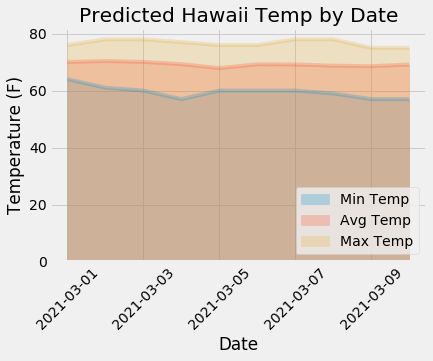

In [24]:
# Plot the daily normals as an area plot with `stacked=False`

temp_normals_df.plot.area(stacked=False, alpha=.25)
plt.xticks( rotation="45")
plt.title("Predicted Hawaii Temp by Date")
plt.legend(loc="lower right")
plt.xlabel("Date")
plt.ylabel("Temperature (F)")
plt.show()


In [25]:

#session.close()
